In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import scipy.io as sio
import torch
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

/home/tseringj/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = {"Long_words": "/home/tseringj/final_project/Long_Words",
               "Short_Long_words": "/home/tseringj/final_project/Short_Long_words",
               "Short_words": "/home/tseringj/final_project/Short_words",
               "Vowels": "/home/tseringj/final_project/Vowels"}

words_dict = {
    "Long_words": ["cooperate", "independent"],
    "Short_Long_words": ["cooperate", "in"],
    "Short_words": ["out", "in", "up"],
    "Vowels": ["a", "i", "u"]
}

numeric_labels = {
    "Long_words": {"cooperate": 0, "independent": 1},
    "Short_Long_words": {"cooperate": 0, "in": 1},
    "Short_words": {"out": 0, "in": 1, "up": 2},
    "Vowels": {"a": 0, "i": 1, "u": 2}
}

In [3]:
datasub2 = sio.loadmat('Long_Words/sub_2b_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub3 = sio.loadmat('Long_Words/sub_3b_ch80_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub6 = sio.loadmat('Long_Words/sub_6_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub7 = sio.loadmat('Long_Words/sub_7_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub9 = sio.loadmat('Long_Words/sub_9c_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub11 = sio.loadmat('Long_Words/sub_11b_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [4]:
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split

In [5]:

matrix_to_load = "eeg_data_wrt_task_rep_no_eog_256Hz_last_beep"

def load_EEG(type, subject_no):
    path = folder_path[type]
    words = words_dict[type]
    for subject_file in os.scandir(path):
        if not (subject_file.is_file() and subject_file.name.endswith('.mat') and
                int(re.search("[0-9]+", subject_file.name).group(0)) == subject_no):
            continue
        mat = sio.loadmat(subject_file.path)[matrix_to_load]
        
        temp = f"{path}/temp_files3"
        if not os.path.exists(temp):
            os.mkdir(temp)
        temp = f"{temp}/{subject_no}"

        if not os.path.exists(temp):
            os.mkdir(temp)
            
        X = []
        Y = []
        for index, eeg in np.ndenumerate(mat):
            temp2 = f"{temp}/{words[index[0]]}_{index[1] + 1}.npy" #storing each trial
            X.append(temp2)
            Y.append(words[index[0]])
            # if eeg.shape[0]>64:
            #     eeg=eeg[:64,:]
           
            if not os.path.exists(temp2):
                np.save(temp2, eeg)
    return np.array(X), np.array(Y)

In [6]:
# # function for data augmentation

# def train_augmentation(X,Y):

#     final_X=np.empty((0,64,1280))
#     label=np.empty((0,1))

    
#     for i in range(len(X)):
#         #result=np.empty((4,64,512))
#         with open(X[i], 'rb') as f:
#             data = np.load(f)
#             # indices = np.arange(1, 17)
#             # indices = np.append(indices, np.arange(33, 49))
#             # indices = np.delete(indices, 9)

#             # Loop through the data with a stride of 64 samples

            

#             final_X = np.vstack((final_X,np.expand_dims(data,axis=0)))        
#             if numeric_labels[type][Y[i]]==0:
#                 label=np.vstack((label, np.zeros((1,1))))
#             else:
#                 label=np.vstack((label, np.ones((1,1))))
            
    
    
        
#     return final_X, label


# # function for data augmentation

# def train_augmentation(X,Y):

#     total_samples=1152
#     # stride=250
#     # epoch_size=512
#     final_X=np.empty((0,60,total_samples))
#     label=np.empty((0,1))
#     # print(f'with total_sample: {total_samples}, epoch size: {epoch_size} and strides: {stride}')
    
#     for i in range(len(X)):
#         #result=np.empty((4,64,512))
#         with open(X[i], 'rb') as f:
#             data = np.load(f)
#             indices = np.arange(1, 32)
#             indices = np.append(indices, np.arange(33, 63))
#             indices = np.delete(indices, 8)
#             data=data[indices,:total_samples]
#             # Loop through the data with a stride of 64 samples
            
#             final_X = np.vstack((final_X,np.expand_dims(data,axis=0)))        
#             if numeric_labels[type][Y[i]]==0:
#                 label=np.vstack((label, np.zeros((1,1))))
#             else:
#                 label=np.vstack((label, np.ones((1,1))))
            
    
    
        
#     return final_X, label

In [7]:
# function for data augmentation

def train_augmentation(X,Y):

    total_samples=1152
    stride=250
    epoch_size=512
    final_X=np.empty((0,60,epoch_size))
    label=np.empty((0,1))
    print(f'with total_sample: {total_samples}, epoch size: {epoch_size} and strides: {stride}')
    
    for i in range(len(X)):
        #result=np.empty((4,64,512))
        with open(X[i], 'rb') as f:
            data = np.load(f)
            indices = np.arange(1, 32)
            indices = np.append(indices, np.arange(33, 63))
            indices = np.delete(indices, 8)
            data=data[indices,:total_samples]
            # Loop through the data with a stride of 64 samples
            
            for j in range(0, total_samples, stride):
                if j+epoch_size >= total_samples:
                    break
            

                final_X = np.vstack((final_X,np.expand_dims(data[:, j:j+epoch_size],axis=0)))        
                if numeric_labels[type][Y[i]]==0:
                    label=np.vstack((label, np.zeros((1,1))))
                else:
                    label=np.vstack((label, np.ones((1,1))))
            
    
    
        
    return final_X, label

In [8]:
def calculate_performance(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1 {f1}')
    return accuracy

In [9]:
def train_model(X_train, X_test, y_train, y_test):

  # Import other classifiers as needed

  # Train classifiers with different n_components values
  model_accuracies={}
  svm_rbf=SVC(kernel='rbf')

  svm_rbf.fit(X_train, y_train)
  y_pred_rbf=svm_rbf.predict(X_test)
  accuracy_rbf=calculate_performance(y_test, y_pred_rbf)
  model_accuracies['svm_rbf']=accuracy_rbf
  
  svm_linear = SVC(kernel='linear')
  svm_linear.fit(X_train, y_train)
  y_pred_linear = svm_linear.predict(X_test)
  print("pca linear performance: ")
  accuracy_linear=calculate_performance(y_test, y_pred_linear)
  model_accuracies['svm_linear']=accuracy_linear

  
  svm_poly = SVC(kernel='poly')
  svm_poly.fit(X_train, y_train)
  y_pred_poly = svm_poly.predict(X_test)
  print("pca linear performance: ")
  accuracy_poly=calculate_performance(y_test, y_pred_poly)
  model_accuracies['svm_poly']=accuracy_poly


  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_pred_rfc = rfc.predict(X_test)
  print("Random Forest performance: ")
  accuracy_rfc=calculate_performance(y_test, y_pred_rfc)
  model_accuracies['rfc']=accuracy_rfc
 
  k = 5  
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred_knn = knn.predict(X_test)
  print("KNN: ")
  accuracy_knn=calculate_performance(y_test, y_pred_knn)
  model_accuracies['knn']=accuracy_knn


  mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000,activation='relu', solver='adam', random_state=42)
  mlp.fit(X_train, y_train)
  y_pred = mlp.predict(X_test)
  y_pred_mlp = [round(value) for value in y_pred]
  print('MLP performance: ')
  accuracy_mlp=calculate_performance(y_test, y_pred_mlp)
  model_accuracies['mlp']=accuracy_mlp


  return model_accuracies

In [10]:
from numpy.linalg import LinAlgError
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [11]:

# def get_data(type,subject_no):
    
#     X,Y=load_EEG(type, subject_no)
#     loo = LeaveOneOut()

#     average_accuracies={}

#     for i, (train_index, test_index) in enumerate(loo.split(X, Y)):
#         train_X = X[train_index]
#         train_y = Y[train_index]
#         test_X = X[test_index]
#         test_y = Y[test_index]
#         X_train, y_train  = train_augmentation(train_X, train_y)
#         X_test, y_test = train_augmentation(test_X, test_y)
#         y_train=y_train.reshape((-1))
#         y_test=y_test.reshape((-1))


#         try:
#             csp = CSP(n_components=4, reg=0.0003, log=False, norm_trace=False)
#             csp.fit(X_train, y_train)
#             X_train_csp = csp.transform(X_train)
#             X_test_csp = csp.transform(X_test)
#         except LinAlgError:
#             print("LinAlgError occurred. Adjusting regularization parameter...")
#             try:
#                 csp = CSP(n_components=4, reg=0.0002, log=False, norm_trace=False)
#                 csp.fit(X_train, y_train)
#                 X_train_csp = csp.transform(X_train)
#                 X_test_csp = csp.transform(X_test)
#             except LinAlgError:
#                 print("LinAlgError occurred again. Consider further adjustments or preprocessing steps.")
                
#                 try:
#                     csp = CSP(n_components=4, reg=0.0001, log=False, norm_trace=False)
#                     csp.fit(X_train, y_train)
#                     X_train_csp = csp.transform(X_train)
#                     X_test_csp = csp.transform(X_test)
#                 except LinAlgError:
#                     print("LinAlgError occurred again. Consider further adjustments or preprocessing steps.")
#         print(f'fold {i} performance: ')
#         accuracies=train_model(X_train_csp, X_test_csp, y_train, y_test)
#         for model_name, accuracy in accuracies.items():
#             if model_name not in average_accuracies:
#                 average_accuracies[model_name] = []
#             average_accuracies[model_name].append(accuracy)
#     for model_name, accuracies in average_accuracies.items():
#         average_accuracy = np.mean(accuracies)
#         std_deviation = np.std(accuracies)
#         print(f"{model_name} Average Accuracy: {average_accuracy}")
#         print(f"{model_name} Standard Deviation: {std_deviation}")


#     return 

In [12]:
from pyriemann.classification import MDM, TSclassifier, FgMDM
from pyriemann.estimation import Covariances
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from pyriemann.channelselection import ElectrodeSelection

from pyriemann.tangentspace import TangentSpace

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [14]:
# def get_data(type,subject_no):
    
#     X,Y=load_EEG(type, subject_no)


#     X_train, y_train  = train_augmentation(X, Y)

#     y_train=y_train.reshape((-1))

#     cv = KFold(n_splits=10, shuffle=True, random_state=42)
#     cov_data_train = Covariances(estimator='lwf').transform(X_train)
    
#     mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
    

#     scores_mdm = cross_val_score(mdm, cov_data_train, y_train, cv=cv, n_jobs=1)
#     print(f"MDM Classification Average Accuracy: {np.mean(scores_mdm)}, MDM Classification Average Std: {np.std(scores_mdm)}")

#     tsc = TSclassifier()
#     # Use scikit-learn Pipeline with cross_val_score function
#     scores_tsc = cross_val_score(tsc, cov_data_train, y_train, cv=cv, n_jobs=1)
#     print(f"TSC Classification Average Accuracy: {np.mean(scores_tsc)}, TSC Classification Average Std: {np.std(scores_tsc)}")

#     lr = LogisticRegression()
#     csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
#     csp = Pipeline([('CSP', csp), ('LogisticRegression', lr)])
#     scores_csp = cross_val_score(csp, X_train, y_train, cv=cv, n_jobs=1)
#     print(f" Classification Average Accuracy: {np.mean(scores_csp)}, MDM Classification Average Std: {np.std(scores_csp)}")

#     return 


In [15]:
# def get_data(type,subject_no):
    
#     X,Y=load_EEG(type, subject_no)
#     kfold=5
#     skf = StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)

#     test_scores=[]

    
#     for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
#       train_X=X[train_index]
#       train_y=Y[train_index]
#       test_X=X[test_index]
#       test_y=Y[test_index]

#       X_train, y_train  = train_augmentation(train_X, train_y)
#       X_test, y_test = train_augmentation(test_X, test_y)
#       y_train=y_train.reshape((-1))
#       y_test=y_test.reshape((-1))
#       #cv = KFold(n_splits=10, shuffle=True, random_state=42)

      
#       cov_data_train = Covariances(estimator='lwf').transform(X_train)
#       cov_data_test=Covariances(estimator='lwf').transform(X_test)
#       ecs=ElectrodeSelection(nelec=30, metric='riemann', n_jobs=1)
#       ecs.fit(cov_data_train, y_train)
#       cov_data_train=ecs.transform(cov_data_train)
#       cov_data_test=ecs.transform(cov_data_test)


#       ts=TangentSpace(metric='riemann', tsupdate=True)
#       data_train=ts.fit_transform(cov_data_train, y_train)
#       data_test=ts.transform(cov_data_test)

#       X_train_tensor = torch.Tensor(data_train)
#       y_train_tensor = torch.Tensor(y_train)
#       X_test_tensor = torch.Tensor(data_test)
#       y_test_tensor = torch.Tensor(y_test)

#       # Create DataLoader for training and test sets
#       train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#       train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#       test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#       test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#       num_classes=len(words_dict[type])

#       # Define your feed-forward neural network
#       class EEGClassifier(nn.Module):
#           def __init__(self):
#               super(EEGClassifier, self).__init__()
#               self.fc1 = nn.Linear(in_features=data_train.shape[1], out_features=100)
#               self.dropout1 = nn.Dropout(p=0.3)
#               self.fc2 = nn.Linear(in_features=100, out_features=100)
#               self.dropout2 = nn.Dropout(p=0.3)
#               self.fc3 = nn.Linear(in_features=100, out_features=32)
#               self.fc4 = nn.Linear(in_features=32, out_features=num_classes)

#           def forward(self, x):
#               x = torch.relu(self.fc1(x))
#               x= self.dropout1(x)
#               x = torch.relu(self.fc2(x))
#               x=self.dropout2(x)
#               x = torch.relu(self.fc3(x))
#               x = self.fc4(x)
#               return x

#       # Create an instance of the EEGClassifier
#       model = EEGClassifier()

#       # Define loss function and optimizer
#       criterion = nn.CrossEntropyLoss()
#       optimizer = optim.Adam(model.parameters(), lr=0.0001)

#       # Train the feed-forward neural network
#       num_epochs = 100
#       for epoch in range(num_epochs):
#           for batch_X, batch_y in train_loader:
#               optimizer.zero_grad()
#               outputs = model(batch_X)
#               loss = criterion(outputs, batch_y.long())
#               loss.backward()
#               optimizer.step()

#       # Evaluate the feed-forward neural network
#       model.eval()
#       with torch.no_grad():
#         correct = 0
#         total = 0
#         for batch_X, batch_y in test_loader:
#             outputs = model(batch_X)
#             _, predicted = torch.max(outputs.data, 1)
#             total += batch_y.size(0)
#             correct += (predicted == batch_y).sum().item()
#       accuracy = correct / total
#       test_scores.append(accuracy)
#       print("Accuracy: {:.2f}%".format(accuracy * 100))
#     print(f"Classification Average Test Accuracy: {np.mean(test_scores)}, Classification Average Test Std: {np.std(test_scores)}")

      


    



#     return 


In [16]:
from sklearn.metrics import cohen_kappa_score

In [17]:
def get_data(type,subject_no, n_elec):
    
    X,Y=load_EEG(type, subject_no)
    kfold=5
    skf = StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)

    test_scores=[]
    kappa_scores=[]
    prediction_arr=[]
    ground_truth_arr=[]
    
    for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
      print(f'fold: *****************{i}*****************')
      train_X, val_X, train_y, val_y = train_test_split(X[train_index], Y[train_index], test_size=0.10, shuffle=True, stratify= Y[train_index], random_state=42)

      test_X=X[test_index]
      test_y=Y[test_index]



      X_train, y_train  = train_augmentation(train_X, train_y)
      X_val, y_val= train_augmentation(val_X, val_y)
      X_test, y_test = train_augmentation(test_X, test_y)
      y_train=y_train.reshape((-1))
      y_val=y_val.reshape((-1))
      y_test=y_test.reshape((-1))
      #cv = KFold(n_splits=10, shuffle=True, random_state=42)
      print(y_train.shape, y_val.shape, y_test.shape)

      
      cov_data_train = Covariances(estimator='lwf').transform(X_train)
      cov_data_val=Covariances(estimator='lwf').transform(X_val)
      cov_data_test=Covariances(estimator='lwf').transform(X_test)
      ecs=ElectrodeSelection(nelec=n_elec, metric='riemann', n_jobs=1)
      ecs.fit(cov_data_train, y_train)
      cov_data_train=ecs.transform(cov_data_train)
      cov_data_val=ecs.transform(cov_data_val)
      cov_data_test=ecs.transform(cov_data_test)


      ts=TangentSpace(metric='riemann', tsupdate=True)
      data_train=ts.fit_transform(cov_data_train, y_train)
      data_val=ts.transform(cov_data_val)
      data_test=ts.transform(cov_data_test)

      X_train_tensor = torch.Tensor(data_train)
      y_train_tensor = torch.Tensor(y_train)
      X_val_tensor = torch.Tensor(data_val)
      y_val_tensor = torch.Tensor(y_val)
      X_test_tensor = torch.Tensor(data_test)
      y_test_tensor = torch.Tensor(y_test)

      # Create DataLoader for training and test sets
      train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
      train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
      val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
      val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
      test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
      test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
      num_classes=len(words_dict[type])

      # Define your feed-forward neural network
      class EEGClassifier(nn.Module):
          def __init__(self):
              super(EEGClassifier, self).__init__()
              self.fc1 = nn.Linear(in_features=data_train.shape[1], out_features=100)
              self.dropout1 = nn.Dropout(p=0.3)
              self.fc2 = nn.Linear(in_features=100, out_features=100)
              self.dropout2 = nn.Dropout(p=0.3)
              self.fc3 = nn.Linear(in_features=100, out_features=32)
              self.dropout3 = nn.Dropout(p=0.3)
              self.fc4 = nn.Linear(in_features=32, out_features=num_classes)

          def forward(self, x):
              x = torch.relu(self.fc1(x))
              x= self.dropout1(x)
              x = torch.relu(self.fc2(x))
              x=self.dropout2(x)
              x = torch.relu(self.fc3(x))
              x = self.dropout3(x)
              x = self.fc4(x)
              return x

      # Create an instance of the EEGClassifier
      model = EEGClassifier()

      # Define loss function and optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.0001)

      # Train the feed-forward neural network


      best_val_loss = float('inf')
      best_model_state_dict = None
      no_improvement_epochs = 0
      early_stopping_epochs = 30

        # Train the feed-forward neural network
      num_epochs = 100
      for epoch in range(num_epochs):
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.long())
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
                val_loss += criterion(outputs, batch_y.long()).item()

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        # Check if the current model performs better on validation set
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        # Print the validation loss and accuracy
        if epoch % 10==0:
          print("Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%"\
                .format(epoch+1, num_epochs, val_loss, val_accuracy * 100))

        # Check for early stopping
        if no_improvement_epochs >= early_stopping_epochs:
            print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(early_stopping_epochs))
            break

        # Load the best model state dict
      model.load_state_dict(best_model_state_dict)

        # ... (rest of the code)


      # Evaluate the feed-forward neural network
      model.eval()
      with torch.no_grad():
        correct = 0
        total = 0
 
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            prediction_arr.extend(predicted.tolist())
            ground_truth_arr.extend(batch_y.tolist())
            total += batch_y.size(0)
            
            correct += (predicted == batch_y).sum().item()
      
      
      accuracy = correct / total
      kappa = 1-((1-accuracy)/(1-(1/num_classes)))
      kappa_scores.append(kappa)
      test_scores.append(accuracy)
      print("Accuracy: {:.2f}%".format(accuracy * 100))
      print("Kappa: {}".format(kappa))
    ground_truth_arr=list(map(int, ground_truth_arr))
    acc=calculate_performance(ground_truth_arr, prediction_arr)
    # print(f"acc: {acc}")
    print(f"Classification Average Test Accuracy: {np.mean(test_scores)}, Classification Average Test Std: {np.std(test_scores)}")
    print(f"Average kappa score: {np.mean(kappa_scores)}, Average kappa Std: {np.std(kappa_scores)}")




    return 


In [18]:
# type="Long_words"
# subject_no=7
# get_data(type, subject_no)

svm_rbf Average Accuracy: 0.52
svm_rbf Standard Deviation: 0.030207614933986434
svm_linear Average Accuracy: 0.5199999999999999
svm_linear Standard Deviation: 0.034776069358108896
svm_poly Average Accuracy: 0.50875
svm_poly Standard Deviation: 0.004999999999999982
rfc Average Accuracy: 0.53
rfc Standard Deviation: 0.03999999999999999
knn Average Accuracy: 0.51875
knn Standard Deviation: 0.050466573095465865
mlp Average Accuracy: 0.5625
mlp Standard Deviation: 0.042938910093294175

In [19]:

# now = datetime.now()
# dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
# with open('Riemannian_Attempt.txt', 'a') as file:
#     sys.stdout = file
#     print('###########################################################################')
#     print(dt_string)
#     type="Long_words"
#     print(type)
#     subject_no=[2,3,6,7,9,11]
#     for i in range(len(subject_no)):
#         print(f'subject no: {subject_no[i]}')
#         get_data(type, subject_no[i])
#         print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
#     sys.stdout = sys.__stdout__

In [57]:
arr=[15,20,25,30,35]
for i in range(len(arr)):
    type="Vowels"
    subject_no=8
    get_data(type, subject_no, arr[i])

fold: *****************0*****************
with total_sample: 1152, epoch size: 512 and strides: 250
with total_sample: 1152, epoch size: 512 and strides: 250
with total_sample: 1152, epoch size: 512 and strides: 250
(648,) (72,) (180,)
Epoch [1/100], Validation Loss: 1.0911, Validation Accuracy: 63.89%
Epoch [11/100], Validation Loss: 0.7681, Validation Accuracy: 66.67%
Epoch [21/100], Validation Loss: 0.6383, Validation Accuracy: 66.67%
Epoch [31/100], Validation Loss: 0.6170, Validation Accuracy: 66.67%
Epoch [41/100], Validation Loss: 0.6272, Validation Accuracy: 63.89%
Epoch [51/100], Validation Loss: 0.6704, Validation Accuracy: 56.94%
Epoch [61/100], Validation Loss: 0.7576, Validation Accuracy: 56.94%
Early stopping triggered. No improvement in validation loss for 30 epochs.
Accuracy: 63.89%
Kappa: 0.45833333333333337
fold: *****************1*****************
with total_sample: 1152, epoch size: 512 and strides: 250
with total_sample: 1152, epoch size: 512 and strides: 250
with 

In [54]:
val=[77.41, 80.625, 76.9, 74.2, 71.9]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


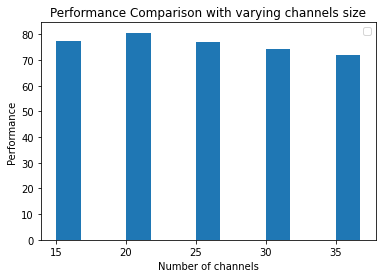

In [51]:
# Creating x-axis values
x = np.arange(len(val))

# Width of the bars
width = 0.35

# Creating a figure and axis
fig, ax = plt.subplots()

# Plotting the bars
rects1= ax.bar(x + width/2, val, width, )

# Adding labels and title
ax.set_xlabel('Number of channels')
ax.set_ylabel('Performance')
ax.set_title('Performance Comparison with varying channels size')
ax.set_xticks(x)
ax.set_xticklabels(['15', '20', '25', '30', '35'])

# Adding a legend
ax.legend()

# Displaying the bar plot
plt.show()

In [34]:

# now = datetime.now()
# dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
# print('###########################################################################')
# with open('Riemannian_Attempt.txt', 'a') as file:
#     sys.stdout = file
#     print('*******************************************************************************')
#     print(dt_string)
#     type="Short_Long_words"
#     print(type)
#     subject_no=[1,5,8,9,10,14]
#     for i in range(len(subject_no)):
#         print(f'subject no: {subject_no[i]}')
#         get_data(type, subject_no[i])
#         print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

#     sys.stdout = sys.__stdout__

In [56]:
# type="Short_words"
# subject_no=12
# get_data(type, subject_no)

TypeError: get_data() missing 1 required positional argument: 'n_elec'

In [55]:
# now = datetime.now()
# dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
# print('###########################################################################')
# with open('Riemannian_Attempt.txt', 'a') as file:
#     sys.stdout = file
#     print('*******************************************************************************')
#     print(dt_string)
#     type="Short_words"
#     print(f'{type}')
#     subject_no=[1,3,5,8,12]
#     for i in range(len(subject_no)):
#         print(f'subject no: {subject_no[i]}')
#         get_data(type, subject_no[i], 15)
#         print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

#     sys.stdout = sys.__stdout__

###########################################################################


In [24]:
with_aug=[63.3, 62.5, 67.7, 80.3, 75.5, 86.5,]
without_aug=[58.5, 51.2, 54.1, 61.1, 64.5, 71.3 ]

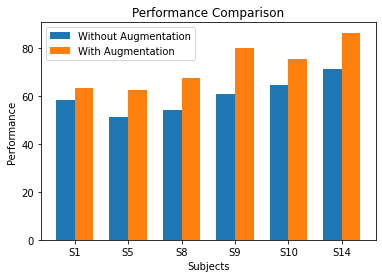

In [25]:
# Creating x-axis values
x = np.arange(len(with_aug))

# Width of the bars
width = 0.35

# Creating a figure and axis
fig, ax = plt.subplots()

# Plotting the bars
rects1 = ax.bar(x - width/2, without_aug, width, label='Without Augmentation')
rects2 = ax.bar(x + width/2, with_aug, width, label='With Augmentation')

# Adding labels and title
ax.set_xlabel('Subjects')
ax.set_ylabel('Performance')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['S1', 'S5', 'S8', 'S9', 'S10', 'S14'])

# Adding a legend
ax.legend()

# Displaying the bar plot
plt.show()

In [26]:
# now = datetime.now()
# dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
# with open('Riemannian_Attempt.txt', 'a') as file:
#     sys.stdout = file
#     print('*******************************************************************************')
#     print(dt_string)
#     type="Vowels"
#     subject_no=[4,5,8,9,11,12,13,15]
#     print(f'{type}')
#     for i in range(len(subject_no)):
#         print(f'subject no: {subject_no[i]}')
#         get_data(type, subject_no[i])
#         print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

#     sys.stdout = sys.__stdout__